## Loading the environments

In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

True

## Importing the packages

In [2]:
from dotenv import load_dotenv
from langchain.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from IPython.display import Image, display
from langgraph.graph import StateGraph , START , END , MessageGraph 
from langchain_core.messages import HumanMessage , AIMessage , SystemMessage
from typing import TypedDict
from typing import Annotated
from langgraph.graph.message import add_messages
from langgraph.graph import MessagesState

In [3]:
model = ChatOpenAI(model="gpt-4.1-mini", temperature=0)

## Some utilities function

In [4]:
# to display the graph
def display_graph(app):
    # this function will display the graph of the app
    try:
        display(Image(app.get_graph().draw_mermaid_png()))
    except Exception as e:
        # This requires some extra dependencies and is optional
        print(e)



# To stream the output of the app
def stream_output(app, input):
    for output in app.stream(input):
        for key,value in output.items():
            print(f"here is output from {key}")
            print("_______")
            print(value)
            print("\n")

## Defining the nodes

In [5]:
def check_price(item: str):
    """Check the price of an item in the store (in INR).

    Args:
        item: name of the item (e.g., 'apple', 'milk')

    Returns:
        Price of each of the item in INR
    """
    prices_inr = {
        "apple": 30.0,      # ₹30 per apple
        "milk": 60.0,       # ₹60 per litre
        "bread": 40.0,      # ₹40 per loaf
        "chocolate": 100.0  # ₹100 per bar
    }
    return prices_inr.get(item.lower(), 0.0)


def add_to_cart(item: str, quantity: int):
    """Add an item to the cart with given quantity.

    Args:
        item: name of the item
        quantity: number of items to add

    Returns:
        Confirmation message
    """
    return f"Added {quantity} x {item} to your cart."



def calculate_total(prices: list[float]):
    """Calculate total bill in INR.

    Args:
        prices: list of item prices

    Returns:
        Total price formatted in INR
    """
    total = sum(prices)
    return f"Total bill: ₹{total:.2f}"

In [6]:
tools_list = [check_price,add_to_cart,calculate_total]

llm_with_tools = model.bind_tools(tools_list)

In [7]:
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# System message (updated for shopping agent)
sys_msg = SystemMessage(content="You are a helpful shopping agent that helps users check prices, add items to their cart, and calculate the total bill in INR.")

# Node
def agent(state: MessagesState):
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("agent", agent)
builder.add_node("tools", ToolNode(tools_list))

# Define edges: these determine the control flow
builder.add_edge(START, "agent")
builder.add_conditional_edges(
    "agent",
    # If the latest message (result) from agent is a tool call -> tools_condition routes to tools
    # If the latest message (result) from agent is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "agent")

memory = MemorySaver()
graph = builder.compile(interrupt_before=["tools"], checkpointer=memory)

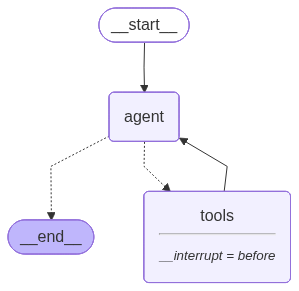

In [8]:
display_graph(graph)

In [9]:
# Input
initial_input = {"messages": HumanMessage(content="How much does an apple cost?")}

# Thread
thread = {"configurable": {"thread_id": "2"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

How much does an apple cost?
================================== Ai Message ==================================
Tool Calls:
  check_price (call_4T8k8IN7KGwJxUQ7WGDNYjE7)
 Call ID: call_4T8k8IN7KGwJxUQ7WGDNYjE7
  Args:
    item: apple


In [10]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  check_price (call_4T8k8IN7KGwJxUQ7WGDNYjE7)
 Call ID: call_4T8k8IN7KGwJxUQ7WGDNYjE7
  Args:
    item: apple
================================= Tool Message =================================
Name: check_price

30.0
================================== Ai Message ==================================

An apple costs 30 INR. Would you like to add some apples to your cart? If yes, please specify the quantity.


In [11]:
# Input
initial_input = {"messages": HumanMessage(content="Please help find me the total price of 10 qty of chocolates")}

# Thread
thread = {"configurable": {"thread_id": "3"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Please help find me the total price of 10 qty of chocolates
================================== Ai Message ==================================
Tool Calls:
  check_price (call_7EOYpPCli7RwgMABNk6UBP2M)
 Call ID: call_7EOYpPCli7RwgMABNk6UBP2M
  Args:
    item: chocolate


In [12]:
state = graph.get_state(thread)

In [13]:
state.next

('tools',)

In [14]:
# Run the graph until the first interruption
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  check_price (call_7EOYpPCli7RwgMABNk6UBP2M)
 Call ID: call_7EOYpPCli7RwgMABNk6UBP2M
  Args:
    item: chocolate
================================= Tool Message =================================
Name: check_price

100.0
================================== Ai Message ==================================
Tool Calls:
  add_to_cart (call_tiJgaHV9TBeJwz6xpVbV240K)
 Call ID: call_tiJgaHV9TBeJwz6xpVbV240K
  Args:
    item: chocolate
    quantity: 10


In [15]:
# Run the graph until the first interruption
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  add_to_cart (call_tiJgaHV9TBeJwz6xpVbV240K)
 Call ID: call_tiJgaHV9TBeJwz6xpVbV240K
  Args:
    item: chocolate
    quantity: 10
================================= Tool Message =================================
Name: add_to_cart

Added 10 x chocolate to your cart.
================================== Ai Message ==================================
Tool Calls:
  calculate_total (call_6VBJak5H0qJ6iGC0p3pMA62D)
 Call ID: call_6VBJak5H0qJ6iGC0p3pMA62D
  Args:
    prices: [100]


In [16]:
# Run the graph until the first interruption
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  calculate_total (call_6VBJak5H0qJ6iGC0p3pMA62D)
 Call ID: call_6VBJak5H0qJ6iGC0p3pMA62D
  Args:
    prices: [100]
================================= Tool Message =================================
Name: calculate_total

Total bill: ₹100.00
================================== Ai Message ==================================

The price of one chocolate is ₹100. For 10 chocolates, the total price is ₹1000. Would you like to proceed with the purchase or add anything else to your cart?


In [19]:
# Input
initial_input = {"messages": HumanMessage(content="Add 3 apples and 1 bread to my cart")}

# Thread
thread = {"configurable": {"thread_id": "4"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

# Get user feedback
user_approval = input("Do you want to call the tool? (yes/no): ")

# Check approval
if user_approval.lower() == "yes":
    
    # If approved, continue the graph execution
    for event in graph.stream(None, thread, stream_mode="values"):
        event['messages'][-1].pretty_print()
        
else:
    print("Operation cancelled by user.")

================================ Human Message =================================

Add 3 apples and 1 bread to my cart
================================== Ai Message ==================================
Tool Calls:
  check_price (call_m9rJGSwRZImHK9YdwX0akZdO)
 Call ID: call_m9rJGSwRZImHK9YdwX0akZdO
  Args:
    item: apple
  check_price (call_vHSXOYDUorYJnjp6xihBacsP)
 Call ID: call_vHSXOYDUorYJnjp6xihBacsP
  Args:
    item: bread
================================== Ai Message ==================================
Tool Calls:
  check_price (call_m9rJGSwRZImHK9YdwX0akZdO)
 Call ID: call_m9rJGSwRZImHK9YdwX0akZdO
  Args:
    item: apple
  check_price (call_vHSXOYDUorYJnjp6xihBacsP)
 Call ID: call_vHSXOYDUorYJnjp6xihBacsP
  Args:
    item: bread
================================= Tool Message =================================
Name: check_price

40.0
================================== Ai Message ==================================
Tool Calls:
  add_to_cart (call_FSAL2pP4mRKEu8qoQk35y8iO)
 Call ID: ca

In [20]:
# Run the graph until the first interruption
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  add_to_cart (call_FSAL2pP4mRKEu8qoQk35y8iO)
 Call ID: call_FSAL2pP4mRKEu8qoQk35y8iO
  Args:
    item: apple
    quantity: 3
  add_to_cart (call_08jqgCQAP4dUOGhvDuzwaWEA)
 Call ID: call_08jqgCQAP4dUOGhvDuzwaWEA
  Args:
    item: bread
    quantity: 1
================================= Tool Message =================================
Name: add_to_cart

Added 1 x bread to your cart.
================================== Ai Message ==================================

I have added 3 apples and 1 bread to your cart. Is there anything else you would like to add?


## Breakpoints with langgraph API

As shown above, we can add interrupt_before=["node"] when compiling the graph that is running in Studio.

However, with the API, you can also pass interrupt_before to the stream method directly.

In [21]:
# This is the URL of the local development server
from langgraph_sdk import get_client
client = get_client(url="http://127.0.0.1:2024")

In [22]:
initial_input = {"messages": HumanMessage(content="Whats the price of 10 apples?")}
thread = await client.threads.create()
async for chunk in client.runs.stream(
    thread["thread_id"],
    "agent",
    input=initial_input,
    stream_mode="values",
    interrupt_before=["tools"],
):
    print(f"Receiving new event of type: {chunk.event}...")
    messages = chunk.data.get('messages', [])
    if messages:
        print(messages[-1])
    print("-" * 50)

Receiving new event of type: metadata...
--------------------------------------------------
Receiving new event of type: values...
{'content': 'Whats the price of 10 apples?', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': 'cdc2bfe2-ca35-407f-be3f-17abc23d07b0', 'example': False}
--------------------------------------------------
Receiving new event of type: values...
{'content': '', 'additional_kwargs': {'tool_calls': [{'id': 'call_gANOcPwPm9gW3gQJZPDX3Ira', 'function': {'arguments': '{"item":"apple"}', 'name': 'check_price'}, 'type': 'function'}], 'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 14, 'prompt_tokens': 166, 'total_tokens': 180, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_95d112f

In [23]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    "agent",
    input=None,
    stream_mode="values",
    interrupt_before=["tools"],
):
    print(f"Receiving new event of type: {chunk.event}...")
    messages = chunk.data.get('messages', [])
    if messages:
        print(messages[-1])
    print("-" * 50)

Receiving new event of type: metadata...
--------------------------------------------------
Receiving new event of type: values...
{'content': '', 'additional_kwargs': {'tool_calls': [{'id': 'call_gANOcPwPm9gW3gQJZPDX3Ira', 'function': {'arguments': '{"item":"apple"}', 'name': 'check_price'}, 'type': 'function'}], 'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 14, 'prompt_tokens': 166, 'total_tokens': 180, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_95d112f245', 'id': 'chatcmpl-CORBVNRESt71qH9Dfm58gxVokdk5v', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, 'type': 'ai', 'name': None, 'id': 'run--4176e4e0-8008-474a-a0dd-d7708ef41f8d-0', 'example': False, 'tool_calls': [{'name': 'check_price', 'args': {'i